# GRU MODEL

In [73]:
# Cases Considered :
# The code provides COBRA model in High-dimensional Time series setup
# Multivariate prediction is of two types : (1) One dimensional output  !! (2) high-dimensional output space.
# The following program deals with high-dimensional output space.
# Pred.Cases : Prediction can be of two types. (i) direct n step prediction [Output space n dimensional] (ii) One step prediction.
#***** The following program deals with high-dimensional output space : Type (1)  Encoder decoder dynamic evolution with one step prediction.
#**** The following program deals with high-dimensional output space : Type (1)  Direct n step of m vectors.  Prediction dimension : (n, m).
# The following program deals with high-dimensional output space : Type (2)  Filter at same step/One step based on all.  Output dimension can be one or more.  

In [74]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.impute import KNNImputer

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense, LSTM, Dropout

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator

import warnings
warnings.filterwarnings('ignore')

In [75]:
df_raw = pd.read_csv("Bitcoin_data.csv")
df_raw.head()

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Bitcoin,BTC,2013-12-27 23:59:59,777.510010,713.599976,763.280029,735.070007,46862700.0,8.955395e+09
1,2,Bitcoin,BTC,2013-12-28 23:59:59,747.059998,705.349976,737.979980,727.830017,32505800.0,8.869919e+09
2,3,Bitcoin,BTC,2013-12-29 23:59:59,748.609985,714.440002,728.049988,745.049988,19011300.0,9.082104e+09
3,4,Bitcoin,BTC,2013-12-30 23:59:59,766.599976,740.239990,741.349976,756.130005,20707700.0,9.217168e+09
4,5,Bitcoin,BTC,2013-12-31 23:59:59,760.580017,738.169983,760.320007,754.010010,20897300.0,9.191325e+09


In [76]:
df_raw = df_raw.drop(columns=['SNo','Name','Symbol'])
df_orig = pd.read_csv("Bitcoin_data.csv")

df_raw['Date'] = pd.to_datetime(df_raw['Date']).dt.date
df_orig['Date'] = pd.to_datetime(df_orig['Date']).dt.date

In [77]:
print(df_raw.head())

         Date        High         Low        Open       Close      Volume  \
0  2013-12-27  777.510010  713.599976  763.280029  735.070007  46862700.0   
1  2013-12-28  747.059998  705.349976  737.979980  727.830017  32505800.0   
2  2013-12-29  748.609985  714.440002  728.049988  745.049988  19011300.0   
3  2013-12-30  766.599976  740.239990  741.349976  756.130005  20707700.0   
4  2013-12-31  760.580017  738.169983  760.320007  754.010010  20897300.0   

      Marketcap  
0  8.955395e+09  
1  8.869919e+09  
2  9.082104e+09  
3  9.217168e+09  
4  9.191325e+09  


In [78]:
df_orig.head()

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Bitcoin,BTC,2013-12-27,777.510010,713.599976,763.280029,735.070007,46862700.0,8.955395e+09
1,2,Bitcoin,BTC,2013-12-28,747.059998,705.349976,737.979980,727.830017,32505800.0,8.869919e+09
2,3,Bitcoin,BTC,2013-12-29,748.609985,714.440002,728.049988,745.049988,19011300.0,9.082104e+09
3,4,Bitcoin,BTC,2013-12-30,766.599976,740.239990,741.349976,756.130005,20707700.0,9.217168e+09
4,5,Bitcoin,BTC,2013-12-31,760.580017,738.169983,760.320007,754.010010,20897300.0,9.191325e+09


In [79]:
# helper functions

In [80]:
def getratio(data):
  ratios = []
  ratios.append(1)
  for i in range(1,len(data)):
    if data[i] ==0 or data[i-1] ==0:
      ratios.append(np.nan)
    else:
      ratios.append(data[i]/data[i-1])
  return ratios

In [81]:
def takeratio(df, col1, col2):
  temp = []
  for i in range(len(df)):
    temp.append(df.loc[i,col1]/df.loc[i,col2])
  return temp

In [82]:
def preprocess(dataf):
  df1 = dataf.copy()
  #Get the the total number of shares in the market using market cap and closing price 
  num_shares = list()
  for i in range(len(df1)):
    num_shares.append(df1.loc[i,'Marketcap']/df1.loc[i,'Close'])
  df1['Numshares'] = num_shares
  df1 = df1.drop(columns=['Marketcap'])
    #Create features
      # 1. ratio of x_[i] and x_[i-1] for each numeric column
  for col in df1.columns:
    if col == 'Date':
      continue
    df1[col+"_ratio"] = getratio(df1[col])
  # 2. ratio of High Low and Close Open
  df1["HighLowRatio"] = takeratio(df1,"High","Low")
  df1["CloseOpenRatio"] = takeratio(df1,"Close","Open")
  return df1

In [83]:
df = preprocess(df_raw)
print(df.head())

         Date        High         Low        Open       Close      Volume  \
0  2013-12-27  777.510010  713.599976  763.280029  735.070007  46862700.0   
1  2013-12-28  747.059998  705.349976  737.979980  727.830017  32505800.0   
2  2013-12-29  748.609985  714.440002  728.049988  745.049988  19011300.0   
3  2013-12-30  766.599976  740.239990  741.349976  756.130005  20707700.0   
4  2013-12-31  760.580017  738.169983  760.320007  754.010010  20897300.0   

      Numshares  High_ratio  Low_ratio  Open_ratio  Close_ratio  Volume_ratio  \
0  1.218305e+07    1.000000   1.000000    1.000000     1.000000      1.000000   
1  1.218680e+07    0.960837   0.988439    0.966854     0.990151      0.693639   
2  1.218993e+07    1.002075   1.012887    0.986544     1.023659      0.584859   
3  1.218992e+07    1.024031   1.036112    1.018268     1.014872      1.089231   
4  1.218992e+07    0.992147   0.997204    1.025588     0.997196      1.009156   

   Numshares_ratio  HighLowRatio  CloseOpenRatio  

In [84]:
df = df.assign(Close_cum = df['Close'])
col = df.pop('Close_cum')
df.insert(4, 'Close_cum', col)
df['Close_cum'] = df['Close_cum'].cumsum()

df = df.assign(Volume_cum = df['Volume'])
col = df.pop('Volume_cum')
df.insert(5, 'Volume_cum', col)
df['Volume_cum'] = df['Volume_cum'].cumsum()

print(df.head())

         Date        High         Low        Open    Close_cum   Volume_cum  \
0  2013-12-27  777.510010  713.599976  763.280029   735.070007   46862700.0   
1  2013-12-28  747.059998  705.349976  737.979980  1462.900024   79368500.0   
2  2013-12-29  748.609985  714.440002  728.049988  2207.950012   98379800.0   
3  2013-12-30  766.599976  740.239990  741.349976  2964.080017  119087500.0   
4  2013-12-31  760.580017  738.169983  760.320007  3718.090027  139984800.0   

        Close      Volume     Numshares  High_ratio  Low_ratio  Open_ratio  \
0  735.070007  46862700.0  1.218305e+07    1.000000   1.000000    1.000000   
1  727.830017  32505800.0  1.218680e+07    0.960837   0.988439    0.966854   
2  745.049988  19011300.0  1.218993e+07    1.002075   1.012887    0.986544   
3  756.130005  20707700.0  1.218992e+07    1.024031   1.036112    1.018268   
4  754.010010  20897300.0  1.218992e+07    0.992147   0.997204    1.025588   

   Close_ratio  Volume_ratio  Numshares_ratio  HighLowRa

In [85]:
'''Create indexes to split dataset'''

times = sorted(df.index.values)
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series

df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]

temp = df_train.drop(columns=['Date']).copy()
imputer = KNNImputer(n_neighbors=3, weights="uniform", missing_values=df.loc[3,'Volume_ratio'])
imputer.fit(temp)

KNNImputer(missing_values=1.089231141479015, n_neighbors=3)

In [86]:
def fillnans(imputer, data):
  temp = data.drop(columns=['Date']).copy()
  data.loc[:,data.columns[1:]] = imputer.transform(temp)
  data = data.set_index('Date')
  return data

In [87]:
df_train = fillnans(imputer, df_train)
df_train = df_train.tail(-1)
df_val = fillnans(imputer, df_val)
df_test = fillnans(imputer, df_test)

In [88]:
# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

print(train_data[:, 5])
print(df_train['Close'])

Training data shape: (2199, 16)
Validation data shape: (275, 16)
Test data shape: (274, 16)
[ 727.83001709  745.04998779  756.13000488 ... 6985.47000061 7344.88418341
 7410.65656642]
Date
2013-12-28     727.830017
2013-12-29     745.049988
2013-12-30     756.130005
2013-12-31     754.010010
2014-01-01     771.400024
                 ...     
2019-12-31    7193.598978
2020-01-01    7200.174393
2020-01-02    6985.470001
2020-01-03    7344.884183
2020-01-04    7410.656566
Name: Close, Length: 2199, dtype: float64


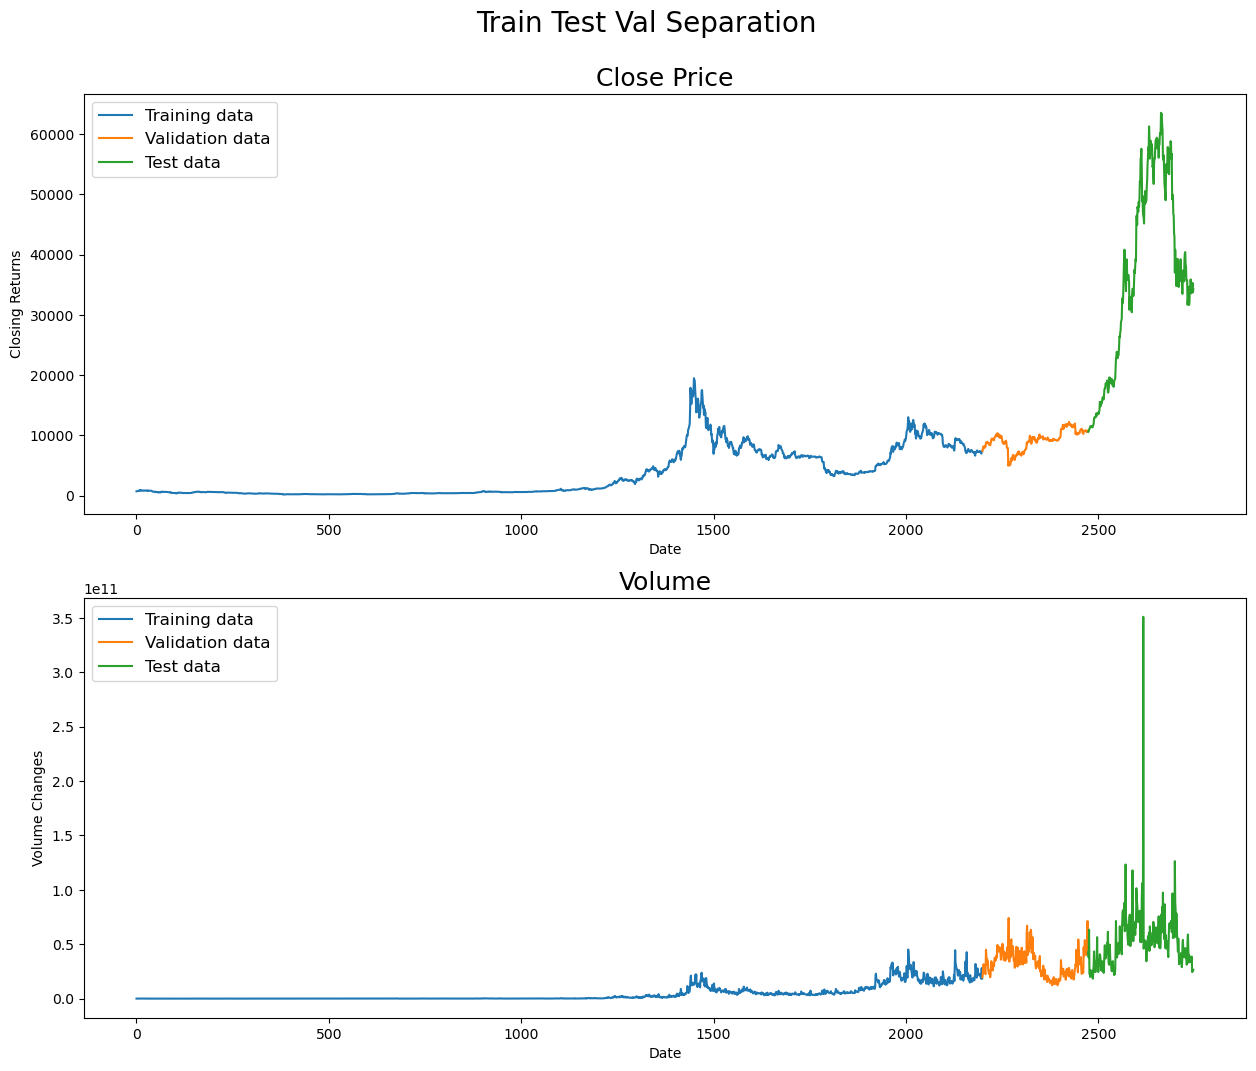

In [89]:
fig = plt.figure(figsize=(15,12))
st = fig.suptitle("Train Test Val Separation", fontsize=20)
st.set_y(0.95)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), train_data[:, 5], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), val_data[:, 5], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), test_data[:, 5], label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Closing Returns')
ax1.set_title("Close Price", fontsize=18)
ax1.legend(loc="best", fontsize=12)

###############################################################################

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), train_data[:, 6], label='Training data')

ax2.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), val_data[:, 6], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), test_data[:, 6], label='Test data')
ax2.set_xlabel('Date')
ax2.set_ylabel('Volume Changes')
ax2.set_title("Volume", fontsize=18)
ax2.legend(loc="best", fontsize=12)
#plt.savefig("1_Cum_Data_Seperation.png", dpi = 80)

plt.show()

###############################################################################


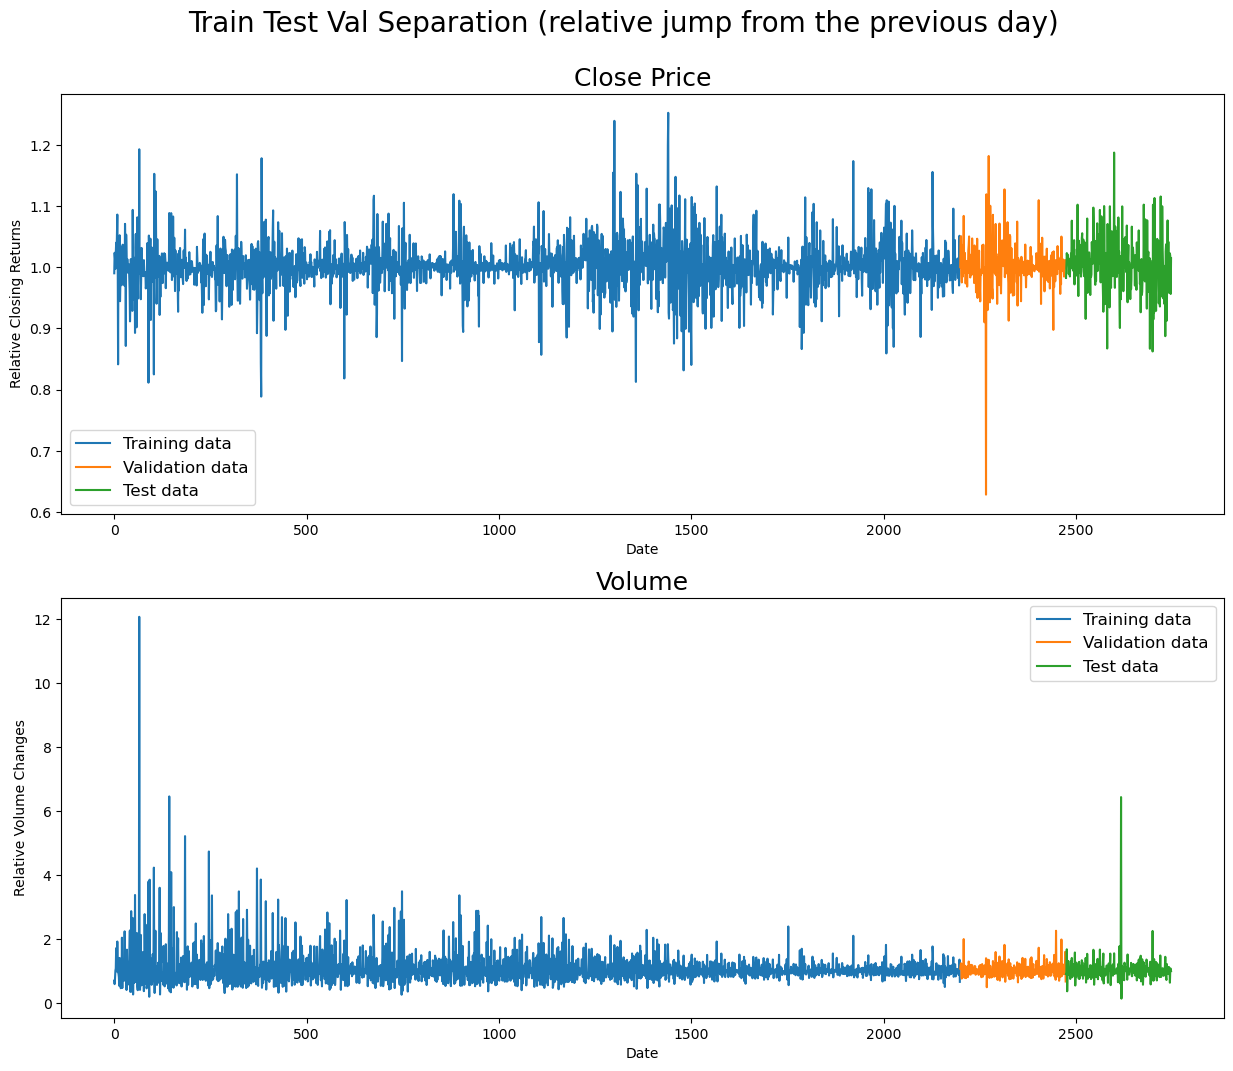

In [90]:
fig = plt.figure(figsize=(15, 12))
st = fig.suptitle("Train Test Val Separation (relative jump from the previous day)", fontsize=20)
st.set_y(0.95)

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['Close_ratio'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Close_ratio'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Close_ratio'], label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Relative Closing Returns')
ax1.set_title("Close Price", fontsize=18)
ax1.legend(loc="best", fontsize=12)


###############################################################################

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df_train['Volume_ratio'], label='Training data')

ax2.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Volume_ratio'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Volume_ratio'], label='Test data')
                   
ax2.set_xlabel('Date')
ax2.set_ylabel('Relative Volume Changes')
ax2.set_title("Volume", fontsize=18)
ax2.legend(loc="best", fontsize=12)

#plt.savefig("1_Cum_Relative_Data_Seperation.png", dpi = 80)

plt.show()


###############################################################################

In [91]:
look_back=20

xtrain = np.reshape(np.array(train_data[:,3:5]), (train_data.shape[0], 2))
xval = np.reshape(np.array(val_data[:, 3:5]), (val_data.shape[0], 2))
xtest = np.reshape(np.array(test_data[:, 3:5]), (test_data.shape[0], 2))


dim = xtrain.shape[1]
print(dim)

2


In [92]:
# For Multivariate set up
def create_dataset_for_lstm(dataset, look_back=20):
    dataX, dataY, scalers = [], [], []
    dataset = np.array(dataset)
    for i in range(dataset.shape[0]-look_back-1):
        a = dataset[i:(i+look_back)]
        scaler = MinMaxScaler(feature_range=(0,1))
        b = scaler.fit_transform(a)
        dataX.append(b)
        y = scaler.transform([dataset[i + look_back]])
        y = np.reshape(y, (y.shape[1]))
        dataY.append(y)
        scalers.append(scaler)
    return np.array(dataX), np.array(dataY), np.array(scalers)

In [93]:
# Let's call this as ToplayerVersion 1 : forward pass in highway


X_train, y_train, scalers_train = create_dataset_for_lstm(xtrain, look_back)
X_val, y_val, scalers_val = create_dataset_for_lstm(xval, look_back)
X_test, y_test, scalers_test = create_dataset_for_lstm(xtest, look_back)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], X_train.shape[2]))

print(X_train.shape[0], X_train.shape[1], X_train.shape[2])
print(y_train.shape[0], y_train.shape[1])

2178 20 2
2178 2


In [94]:
model = models.Sequential()
model.add(GRU(units = 100, use_bias=True, activation = 'relu', return_sequences = False, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.7))
model.add(Dense(units = 2))

callback = tf.keras.callbacks.ModelCheckpoint('gru_baseline.hdf5', 
                                              monitor='val_loss', 
                                              save_best_only=True, 
                                              verbose=1)


model.compile(optimizer = 'Adamax', loss = 'mse', metrics = ['mae','mape'])

history = model.fit(X_train, y_train, epochs = 50, batch_size = 32, verbose=1,
                    callbacks=[callback],
                    validation_data=(X_val, y_val))

Epoch 1/50
67/69 [============================>.] - ETA: 0s - loss: 0.3707 - mae: 0.5106 - mape: 48.3997
Epoch 1: val_loss improved from inf to 0.02624, saving model to gru_baseline.hdf5
69/69 [==============================] - 3s 15ms/step - loss: 0.3670 - mae: 0.5072 - mape: 48.0730 - val_loss: 0.0262 - val_mae: 0.1609 - val_mape: 15.2554
Epoch 2/50
65/69 [===========================>..] - ETA: 0s - loss: 0.1259 - mae: 0.2891 - mape: 27.4143
Epoch 2: val_loss improved from 0.02624 to 0.00847, saving model to gru_baseline.hdf5
69/69 [==============================] - 1s 11ms/step - loss: 0.1258 - mae: 0.2891 - mape: 27.4150 - val_loss: 0.0085 - val_mae: 0.0904 - val_mape: 8.5661
Epoch 3/50
65/69 [===========================>..] - ETA: 0s - loss: 0.1086 - mae: 0.2654 - mape: 25.1684
Epoch 3: val_loss did not improve from 0.00847
69/69 [==============================] - 1s 11ms/step - loss: 0.1088 - mae: 0.2657 - mape: 25.1906 - val_loss: 0.0116 - val_mae: 0.1061 - val_mape: 10.0553
Epo

Epoch 27/50
65/69 [===========================>..] - ETA: 0s - loss: 0.0349 - mae: 0.1497 - mape: 14.1899
Epoch 27: val_loss improved from 0.00191 to 0.00141, saving model to gru_baseline.hdf5
69/69 [==============================] - 1s 11ms/step - loss: 0.0349 - mae: 0.1499 - mape: 14.2053 - val_loss: 0.0014 - val_mae: 0.0355 - val_mape: 3.3562
Epoch 28/50
66/69 [===========================>..] - ETA: 0s - loss: 0.0341 - mae: 0.1492 - mape: 14.1350
Epoch 28: val_loss improved from 0.00141 to 0.00079, saving model to gru_baseline.hdf5
69/69 [==============================] - 1s 11ms/step - loss: 0.0341 - mae: 0.1493 - mape: 14.1461 - val_loss: 7.9292e-04 - val_mae: 0.0252 - val_mape: 2.3786
Epoch 29/50
64/69 [==========================>...] - ETA: 0s - loss: 0.0325 - mae: 0.1444 - mape: 13.6880
Epoch 29: val_loss did not improve from 0.00079
69/69 [==============================] - 1s 11ms/step - loss: 0.0326 - mae: 0.1452 - mape: 13.7583 - val_loss: 0.0023 - val_mae: 0.0458 - val_mape

In [95]:
#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)


print(train_pred.shape)
print(val_pred.shape)
print(test_pred.shape)

8/8 [==============================] - 0s 4ms/step
(2178, 2)
(254, 2)
(253, 2)


In [96]:
# Calculate loss for all datasets
train_loss = model.evaluate(X_train, y_train, verbose=0)
val_loss = model.evaluate(X_val, y_val, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)

# Calculate MAE for each target variable and dataset
from sklearn.metrics import mean_absolute_error
train_mae = mean_absolute_error(y_train, train_pred, multioutput='raw_values')
val_mae = mean_absolute_error(y_val, val_pred, multioutput='raw_values')
test_mae = mean_absolute_error(y_test, test_pred, multioutput='raw_values')

# Print evaluation metrics for all datasets
print('Evaluation metrics')
for i in range(train_mae.shape[0]):
    print('Target Variable {}:'.format(i))
    print('Test Data - Loss: {:.4f}, MAE: {:.4f}'.format(test_loss[i], test_mae[i]))
    print('Training Data - Loss: {:.4f}, MAE: {:.4f}'.format(train_loss[i], train_mae[i]))
    print('Validation Data - Loss: {:.4f}, MAE: {:.4f}'.format(val_loss[i], val_mae[i]))

Evaluation metrics
Target Variable 0:
Test Data - Loss: 0.0010, MAE: 0.0311
Training Data - Loss: 0.0011, MAE: 0.0289
Validation Data - Loss: 0.0008, MAE: 0.0287
Target Variable 1:
Test Data - Loss: 0.0280, MAE: 0.0248
Training Data - Loss: 0.0279, MAE: 0.0269
Validation Data - Loss: 0.0265, MAE: 0.0243


In [97]:
for i in range(np.array(train_pred).shape[0]):
      train_pred[i] = scalers_train[i].inverse_transform([train_pred[i]]).reshape((dim,))
      y_train[i] = scalers_train[i].inverse_transform([y_train[i]]).reshape((dim,))
      
for i in range(np.array(val_pred).shape[0]):
      val_pred[i] = scalers_val[i].inverse_transform([val_pred[i]]).reshape((dim,))
      #print(trainPredict[i])
      y_val[i] = scalers_val[i].inverse_transform([y_val[i]]).reshape((dim,))

for i in range(np.array(test_pred).shape[0]):
      test_pred[i] = scalers_test[i].inverse_transform([test_pred[i]]).reshape((dim,))
      y_test[i] = scalers_test[i].inverse_transform([y_test[i]]).reshape((dim,))

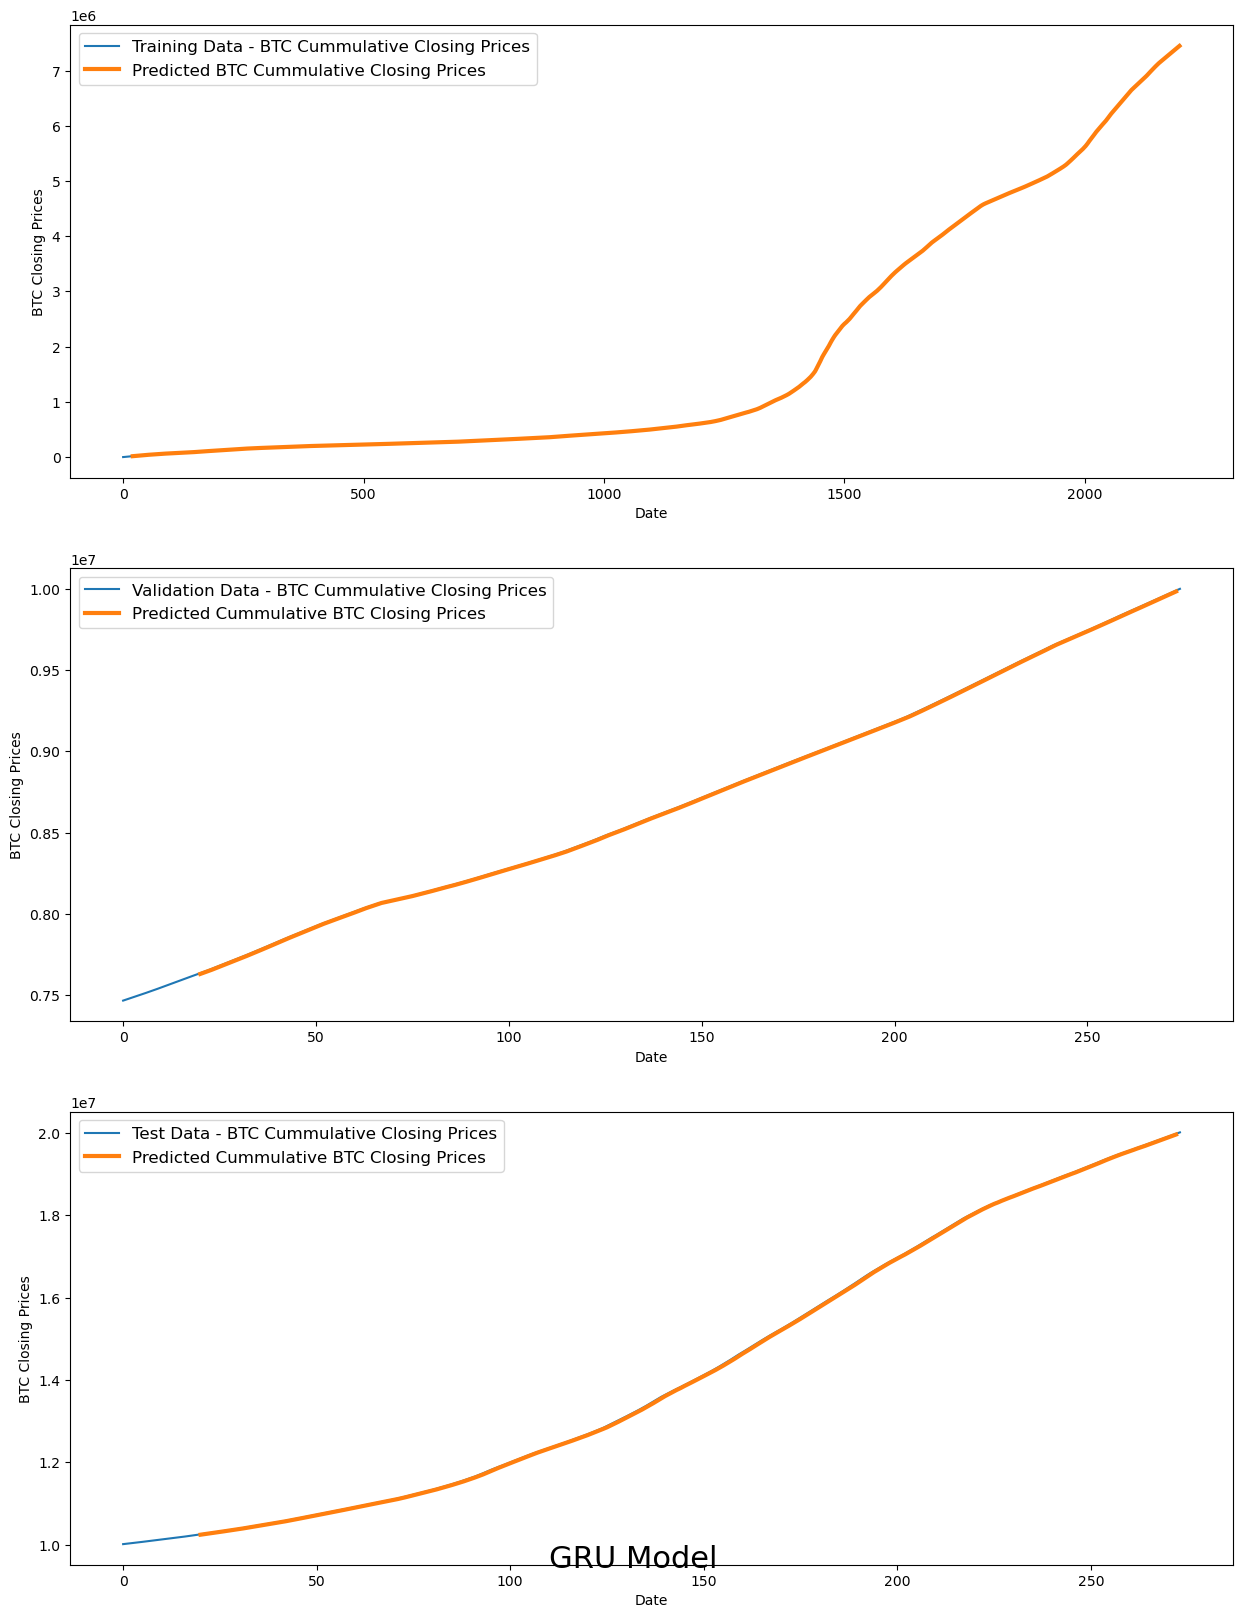

In [98]:
'''Display results'''
test_col = 3

fig = plt.figure(figsize=(15, 20))
st = fig.suptitle("GRU Model", fontsize=22)
st.set_y(0.12)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, test_col], label='Training Data - BTC Cummulative Closing Prices')
ax11.plot(np.arange(look_back, train_pred.shape[0]+look_back), train_pred[:,0], linewidth=3, label='Predicted BTC Cummulative Closing Prices')
ax11.set_title("", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('BTC Closing Prices')
ax11.legend(loc="best", fontsize=12)


#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, test_col], label='Validation Data - BTC Cummulative Closing Prices')
ax21.plot(np.arange(look_back, val_pred.shape[0]+look_back), val_pred[:,0], linewidth=3, label='Predicted Cummulative BTC Closing Prices')
ax21.set_title("", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('BTC Closing Prices')
ax21.legend(loc="best", fontsize=12)



#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, test_col], label='Test Data - BTC Cummulative Closing Prices')
ax31.plot(np.arange(look_back, test_pred.shape[0]+look_back), test_pred[:,0], linewidth=3, label='Predicted Cummulative BTC Closing Prices')
ax31.set_title("", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('BTC Closing Prices')
ax31.legend(loc="best", fontsize=12)


#plt.savefig("1_Predicted_Vs_Original_Cummulative_Closing_Series.png", dpi = 80)

plt.show()

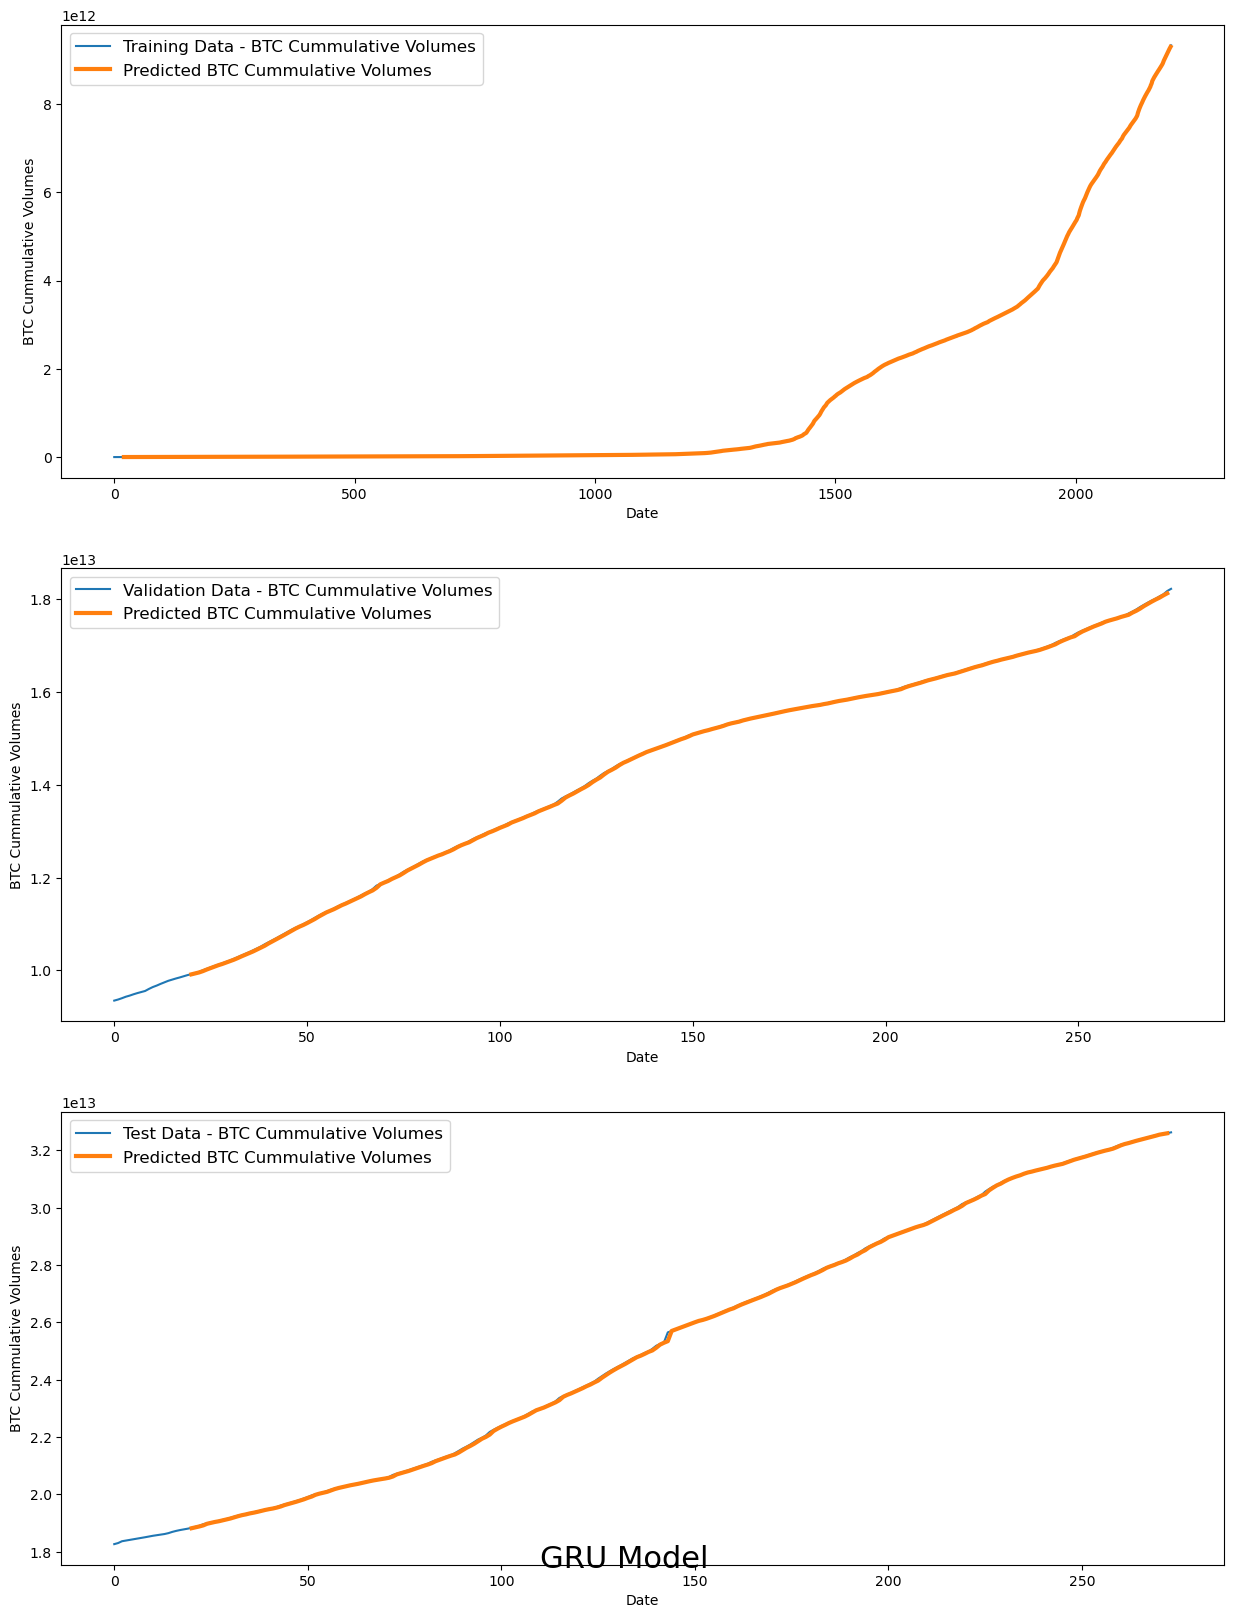

In [99]:
fig = plt.figure(figsize=(15, 20))
st = fig.suptitle("GRU Model", fontsize=22)
st.set_y(0.12)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 4], label='Training Data - BTC Cummulative Volumes')
ax11.plot(np.arange(look_back, train_pred.shape[0]+look_back), train_pred[:,-1], linewidth=3, label='Predicted BTC Cummulative Volumes')
ax11.set_title("", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('BTC Cummulative Volumes')
ax11.legend(loc="best", fontsize=12)


#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 4], label='Validation Data - BTC Cummulative Volumes')
ax21.plot(np.arange(look_back, val_pred.shape[0]+look_back), val_pred[:,-1], linewidth=3, label='Predicted BTC Cummulative Volumes')
ax21.set_title("", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('BTC Cummulative Volumes')
ax21.legend(loc="best", fontsize=12)


#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 4], label='Test Data - BTC Cummulative Volumes')
ax31.plot(np.arange(look_back, test_pred.shape[0]+look_back), test_pred[:,-1], linewidth=3, label='Predicted BTC Cummulative Volumes')
ax31.set_title("", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('BTC Cummulative Volumes')
ax31.legend(loc="best", fontsize=12)




#plt.savefig("1_Predicted_Vs_Original_Cummulative_Volume_Series.png", dpi = 80)

plt.show()

In [100]:
# convert cumulative data to normal data
def convert_cumulative_to_original_column_wise(cumulative_array):
    n_rows, n_cols = cumulative_array.shape
    original_array = np.zeros((n_rows, n_cols), dtype=cumulative_array.dtype)

    for i in range(n_cols):
        original_array[0, i] = cumulative_array[0, i]

        for j in range(1, n_rows):
            original_array[j, i] = cumulative_array[j, i] - cumulative_array[j-1, i]

    return original_array

In [101]:
train_pred = convert_cumulative_to_original_column_wise(train_pred)
test_pred = convert_cumulative_to_original_column_wise(test_pred)
val_pred = convert_cumulative_to_original_column_wise(val_pred)

xtrain = convert_cumulative_to_original_column_wise(xtrain)
xval = convert_cumulative_to_original_column_wise(xval)
xtest = convert_cumulative_to_original_column_wise(xtest)

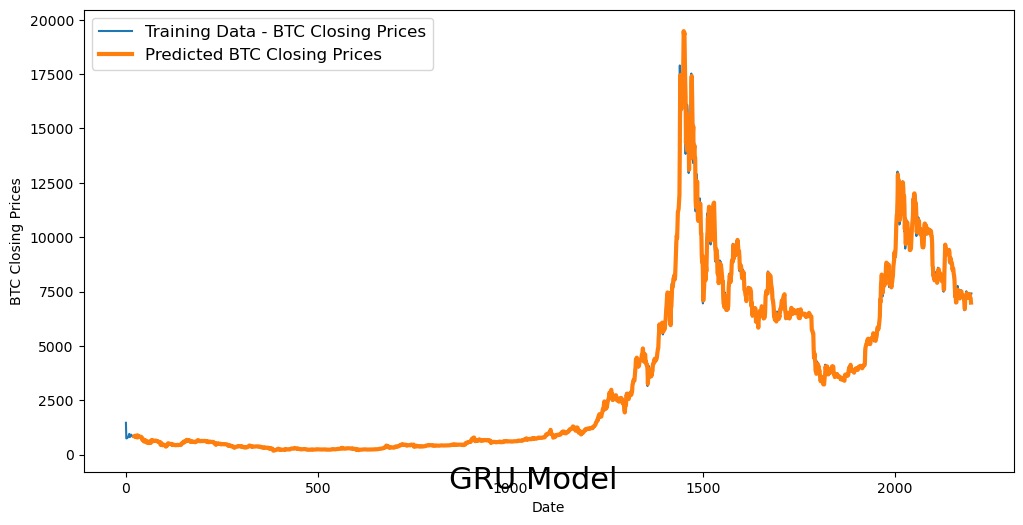

In [102]:
'''Display results'''

fig = plt.figure(figsize=(12, 6))
st = fig.suptitle("GRU Model", fontsize=22)
st.set_y(0.12)

#Plot training data results
ax11 = fig.add_subplot(111)
ax11.plot(xtrain[:, 0], label='Training Data - BTC Closing Prices')
ax11.plot(np.arange(look_back+2, train_pred.shape[0]+look_back), train_pred[2:,0], linewidth=3, label='Predicted BTC Closing Prices')
ax11.set_title("", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('BTC Closing Prices')
ax11.legend(loc="best", fontsize=12)


plt.savefig("2_Cum_Predicted_Vs_Original_Training_Closing_Data.png", dpi = 80)


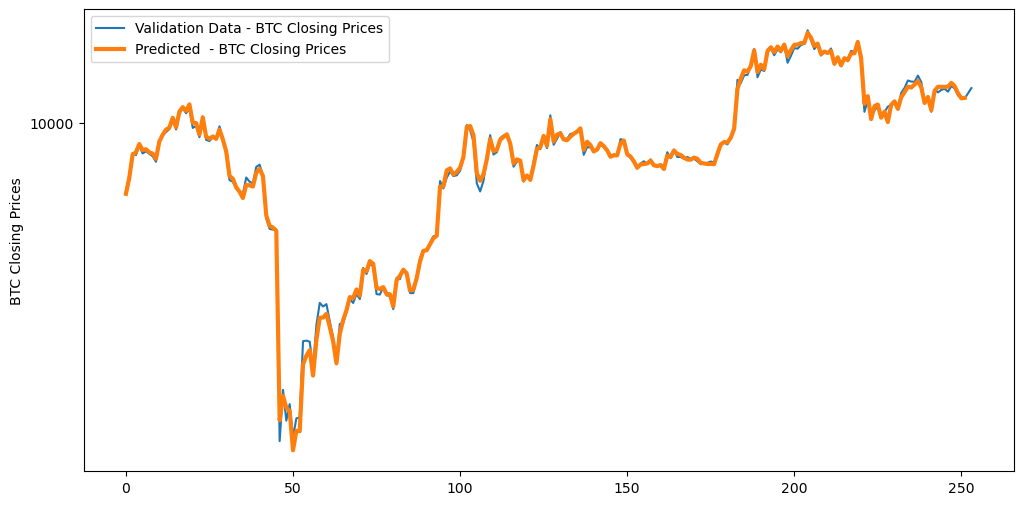

In [103]:
fig = plt.figure(figsize=(12, 6))
# create a plot

plt.plot(np.log(xval[21:,0]), label='Validation Data - BTC Closing Prices')
plt.plot(np.log(val_pred[2:,0]), linewidth=3, label='Predicted  - BTC Closing Prices')

# set the y-axis label and tick labels
plt.ylabel('BTC Closing Prices')
yticks = [10**i for i in range(4,5)]
plt.yticks(np.log(yticks), yticks)

plt.legend()

plt.savefig("2_Cum_Predicted_Vs_Original_Validation_Closing_Data.png", dpi = 80)


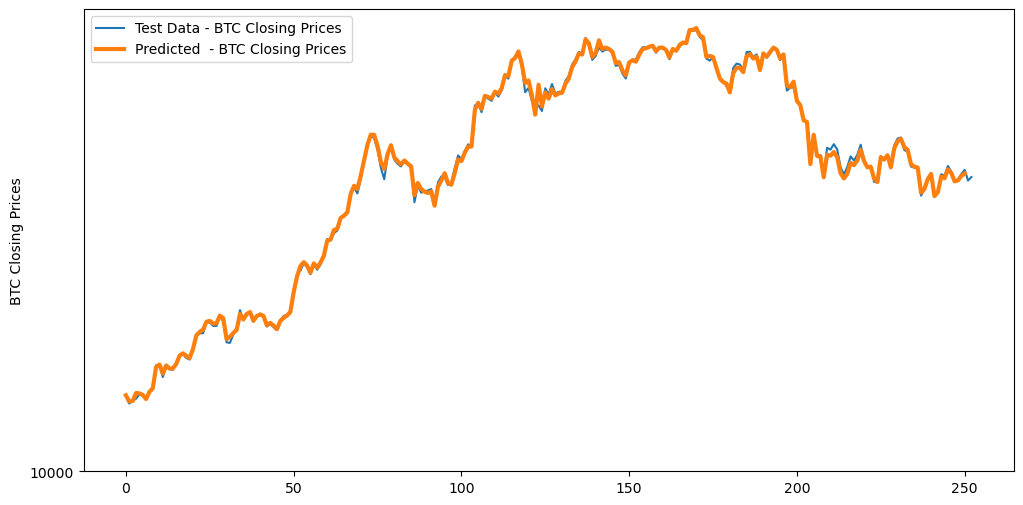

In [104]:
fig = plt.figure(figsize=(12, 6))
# create a plot

plt.plot(np.log(xtest[21:,0]), label='Test Data - BTC Closing Prices')
plt.plot(np.log(test_pred[2:,0]), linewidth=3, label='Predicted  - BTC Closing Prices')

# set the y-axis label and tick labels
plt.ylabel('BTC Closing Prices')
yticks = [10**i for i in range(4,5)]
plt.yticks(np.log(yticks), yticks)

plt.legend()

plt.savefig("2_Cum_Predicted_Vs_Original_Test_Closing_Data.png", dpi = 80)


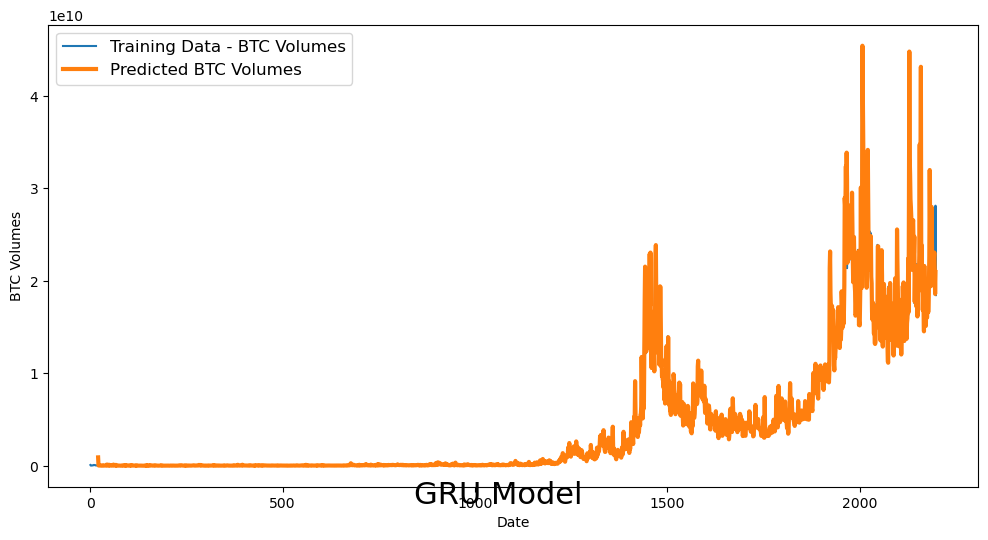

In [105]:
fig = plt.figure(figsize=(12, 6))
st = fig.suptitle("GRU Model", fontsize=22)
st.set_y(0.12)

#Plot training data results
ax11 = fig.add_subplot(111)
ax11.plot(xtrain[:, 1], label='Training Data - BTC Volumes')
ax11.plot(np.arange(look_back, train_pred.shape[0]+look_back), train_pred[:,-1], linewidth=3, label='Predicted BTC Volumes')
ax11.set_title("", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('BTC Volumes')
ax11.legend(loc="best", fontsize=12)

plt.savefig("2_Cum_Predicted_Vs_Original_Training_Volume_Data.png", dpi = 80)


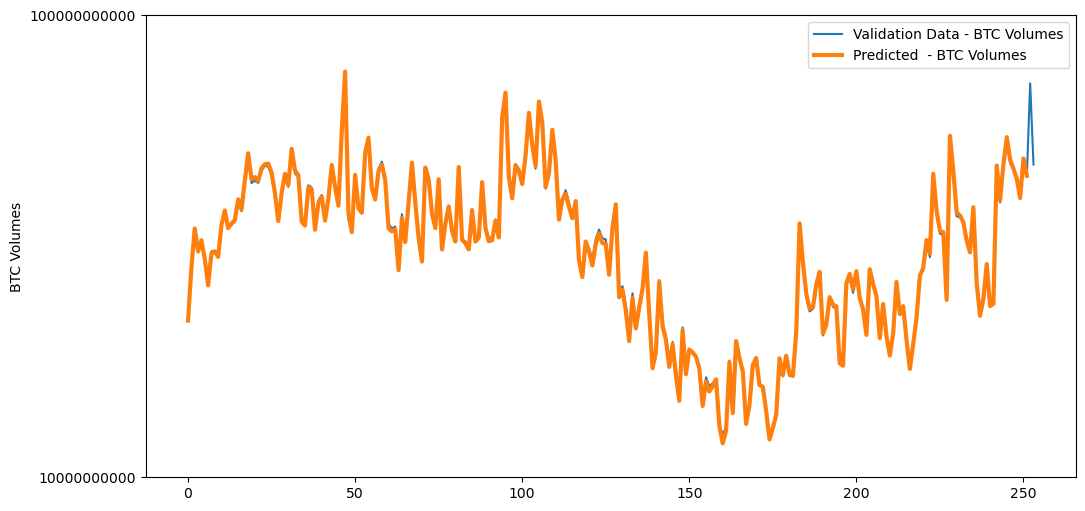

In [106]:
fig = plt.figure(figsize=(12, 6))
# create a plot

plt.plot(np.log(xval[21:,1]), label='Validation Data - BTC Volumes')
plt.plot(np.log(val_pred[2:,1]), linewidth=3, label='Predicted  - BTC Volumes')

# set the y-axis label and tick labels
plt.ylabel('BTC Volumes')
yticks = [10**i for i in range(10,12)]
plt.yticks(np.log(yticks), yticks)

plt.legend()

plt.savefig("2_Cum_Predicted_Vs_Original_Validation_Volume_Data.png", dpi = 80)


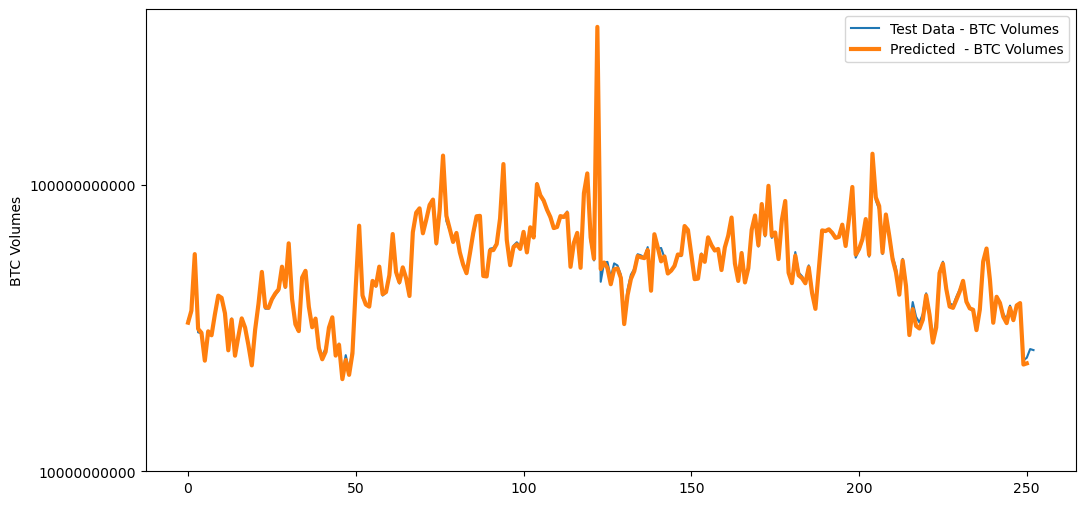

In [107]:
fig = plt.figure(figsize=(12, 6))
# create a plot

plt.plot(np.log(xtest[21:,1]), label='Test Data - BTC Volumes')
plt.plot(np.log(test_pred[2:,1]), linewidth=3, label='Predicted  - BTC Volumes')

# set the y-axis label and tick labels
plt.ylabel('BTC Volumes')
yticks = [10**i for i in range(10,12)]
plt.yticks(np.log(yticks), yticks)

plt.legend()

plt.savefig("2_Cum_Predicted_Vs_Original_Test_Volume_Data.png", dpi = 80)
